In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras


In [2]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.6 MB/s eta 0:00:00


In [45]:
pip install tensorflow

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import keras_tuner as kt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.layers import Dropout
from statsmodels.tsa.arima.model import ARIMA
print('all files ckeck ')

all files ckeck 


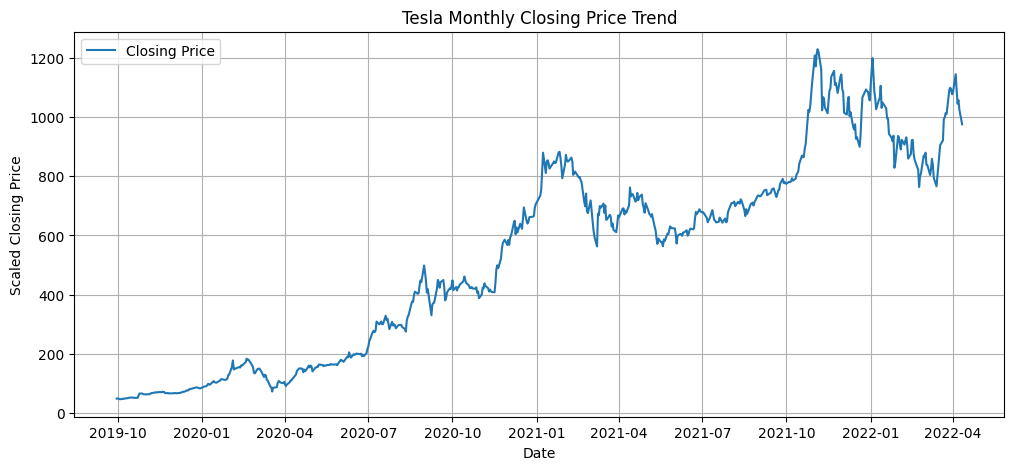

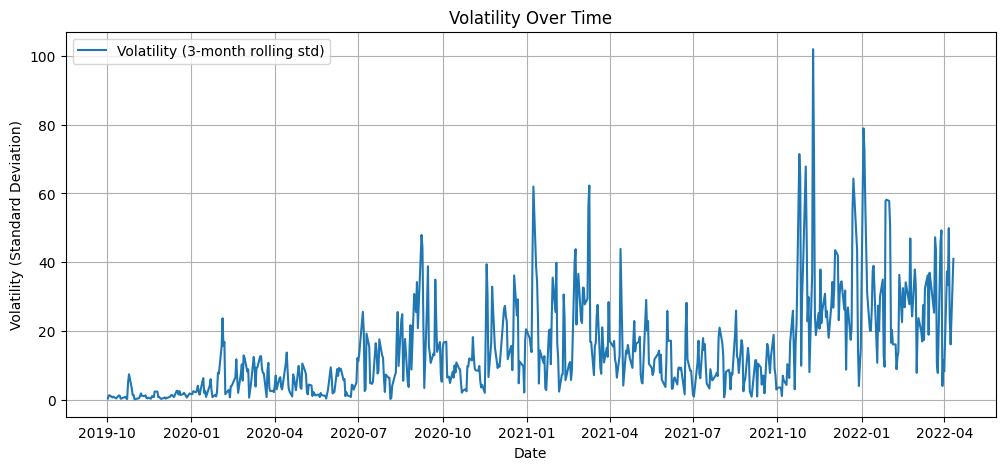

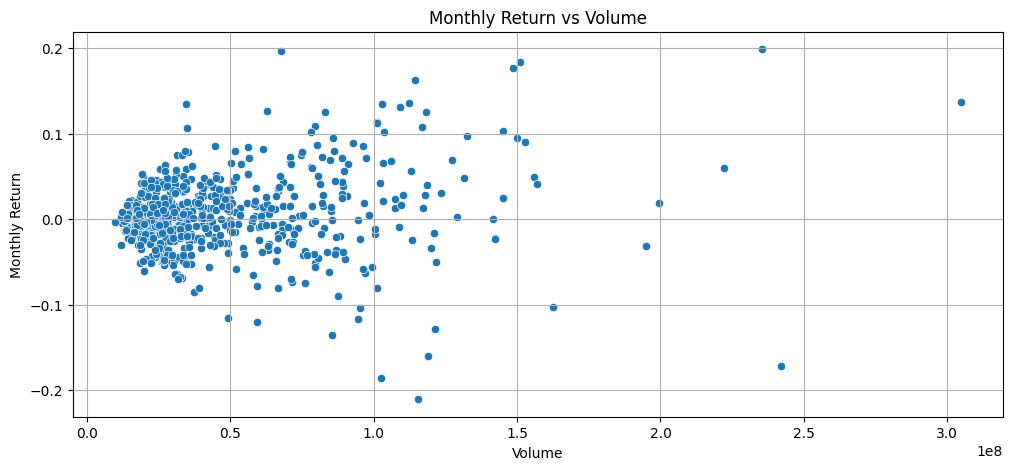

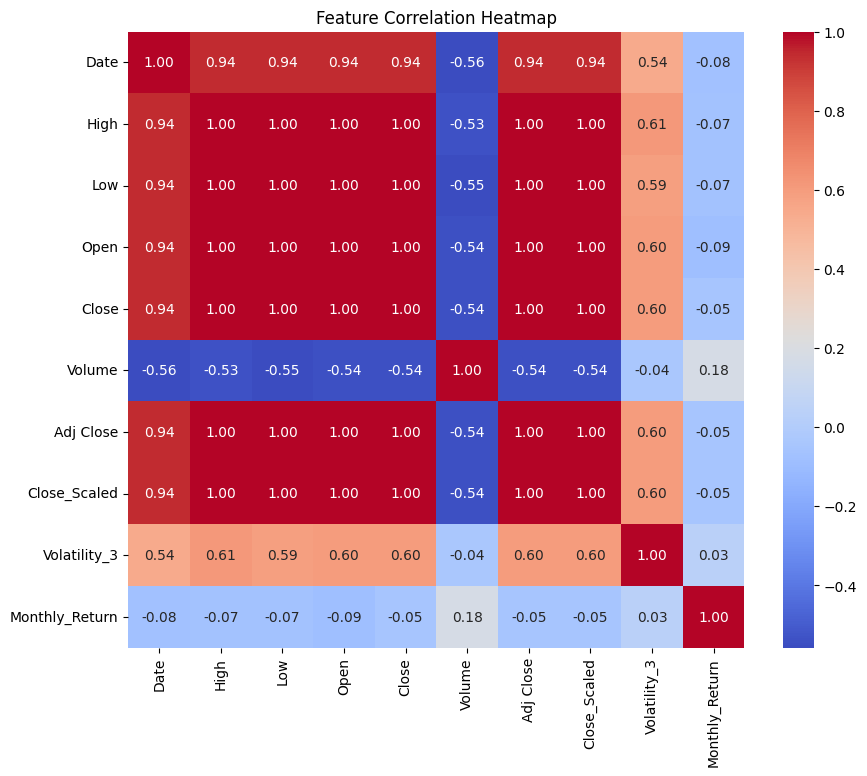

 Potential spike:
 Empty DataFrame
Columns: [Date, Monthly_Return]
Index: []


In [92]:
# Closing Price Over Time
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'], label='Closing Price')
plt.title('Tesla Monthly Closing Price Trend')
plt.xlabel('Date')
plt.ylabel('Scaled Closing Price')
plt.grid(True)
plt.legend()
plt.show()

# Volatility Plot
df['Volatility_3'] = df['Close'].rolling(window=3).std()

plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Volatility_3'], label='Volatility (3-month rolling std)')
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation)')
plt.grid(True)
plt.legend()
plt.show()

# Volume vs Price Movement
plt.figure(figsize=(12, 5))
df['Monthly_Return'] = df['Close'].pct_change()
sns.scatterplot(x='Volume', y='Monthly_Return', data=df)
plt.title('Monthly Return vs Volume')
plt.xlabel('Volume')
plt.ylabel('Monthly Return')
plt.grid(True)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Feature Correlation Heatmap')
plt.show()

# Large spikes detection
threshold = 2.5  # Customize threshold
outliers = df[abs(df['Monthly_Return']) > threshold]
print(" Potential spike:\n", outliers[['Date', 'Monthly_Return']])

# converting to supervised format
def create_supervised_data(df, target_col='Close', window=3):
    X, y = [], []
    for i in range(window, len(df)):
        X.append(df[target_col].values[i-window:i])
        y.append(df[target_col].values[i])
    return pd.DataFrame(X), pd.Series(y)

X, y = create_supervised_data(df, window=3)


Linear Regression MAE: 31.77
Linear Regression RMSE: 41.74


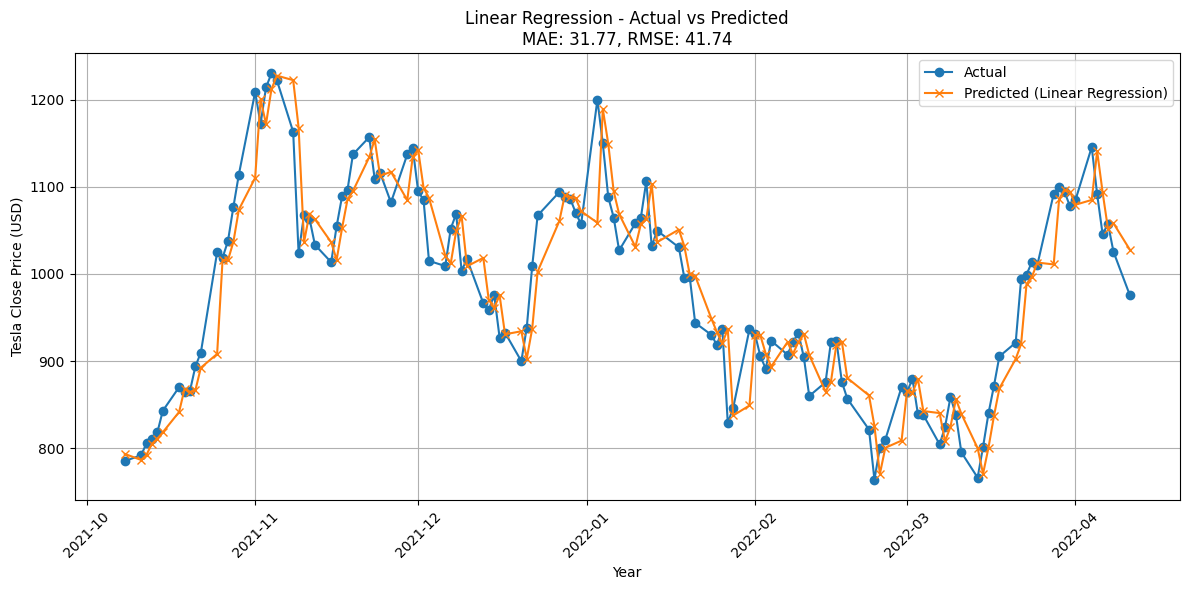

In [88]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load dataset
data = pd.read_csv('/content/drive/My Drive/TSLA.csv')
df = data.copy()

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Scale the target column
scaler = MinMaxScaler()
df['Close_Scaled'] = scaler.fit_transform(df[['Close']])

# Create supervised data
def create_supervised_data(data, window=3):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_supervised_data(df['Close_Scaled'].values, window=window_size)

# Train-test split (no shuffle)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Train Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict
pred_lr_scaled = model_lr.predict(X_test)

# Inverse transform predictions and actual values
pred_lr = scaler.inverse_transform(pred_lr_scaled.reshape(-1, 1)).flatten()
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
mae = mean_absolute_error(y_test_unscaled, pred_lr)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, pred_lr))

print(f"Linear Regression MAE: {mae:.2f}")
print(f"Linear Regression RMSE: {rmse:.2f}")

# Create a date index aligned with y_test
date_index = df['Date'].values[window_size + split:]  # match length of y_test

# Plot Actual vs Predicted with real date labels
plt.figure(figsize=(12, 6))
plt.plot(date_index, y_test_unscaled, label='Actual', marker='o')
plt.plot(date_index, pred_lr, label='Predicted (Linear Regression)', marker='x')
plt.title(f'Linear Regression - Actual vs Predicted\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Year')
plt.ylabel('Tesla Close Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



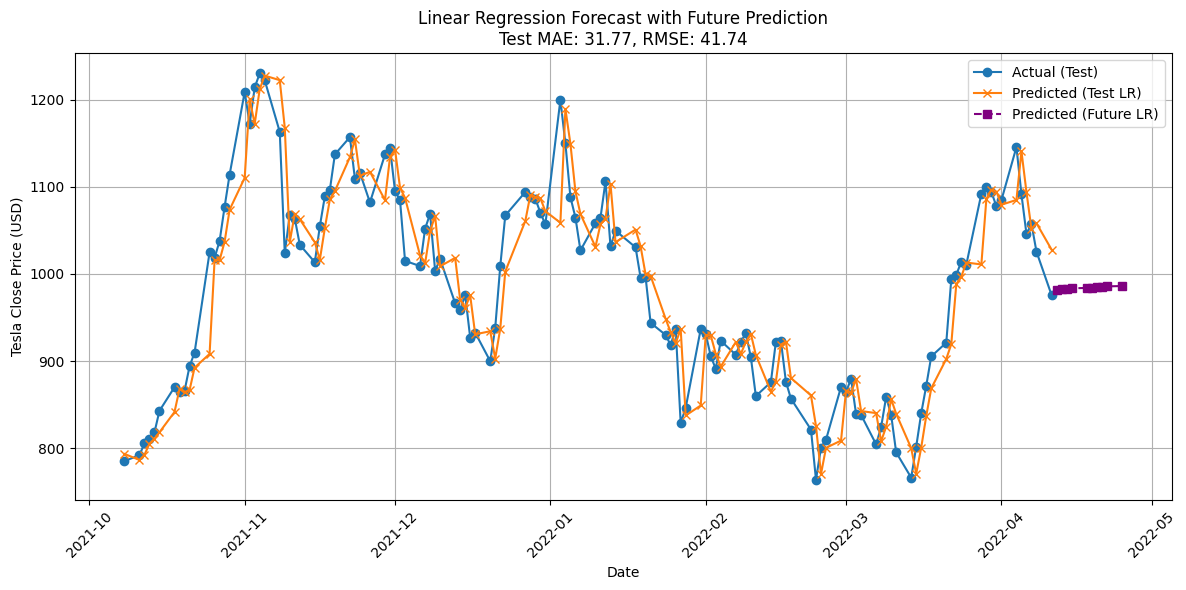


Predicted Tesla closing prices for next future days (Linear Regression):
2022-04-12: 981.23
2022-04-13: 982.84
2022-04-14: 983.05
2022-04-15: 983.47
2022-04-18: 983.92
2022-04-19: 984.37
2022-04-20: 984.81
2022-04-21: 985.25
2022-04-22: 985.69
2022-04-25: 986.13


In [89]:
# LINEAR REGRESSION FUTURE RECURSIVE PREDICTION
def predict_future_recursive_lr(model, last_window, num_predictions, scaler):
    predictions_scaled = []
    current_window = last_window.copy()

    for _ in range(num_predictions):
        input_data = current_window.reshape(1, -1)  # Linear regression expects 2D input
        pred_scaled = model.predict(input_data)[0]
        predictions_scaled.append(pred_scaled)

        # Update current window: drop first, append pred_scaled
        current_window = np.append(current_window[1:], pred_scaled)

    # Inverse scale predictions
    predictions_unscaled = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()
    return predictions_unscaled

# Prepare last window
last_window_scaled = df['Close_Scaled'].values[-window_size:]  # last window_size points

# Predict future points
num_future_predictions = 10  # or more if you want
future_prices_lr = predict_future_recursive_lr(model_lr, last_window_scaled, num_future_predictions, scaler)

# Generate future dates
future_dates = pd.bdate_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=num_future_predictions)

#  Plot actual, predicted test, and future
plt.figure(figsize=(12, 6))
plt.plot(date_index, y_test_unscaled, label='Actual (Test)', marker='o')
plt.plot(date_index, pred_lr, label='Predicted (Test LR)', marker='x')
plt.plot(future_dates, future_prices_lr, label='Predicted (Future LR)', marker='s', linestyle='--', color='purple')

plt.title(f'Linear Regression Forecast with Future Prediction\nTest MAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Date')
plt.ylabel('Tesla Close Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print future predictions ===
print("\nPredicted Tesla closing prices for next future days (Linear Regression):")
for date, price in zip(future_dates, future_prices_lr):
    print(f"{date.date()}: {price:.2f}")


/tmp/ipython-input-8-1179819322.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(last_date, periods=forecast_steps + 1, freq='M')[1:]


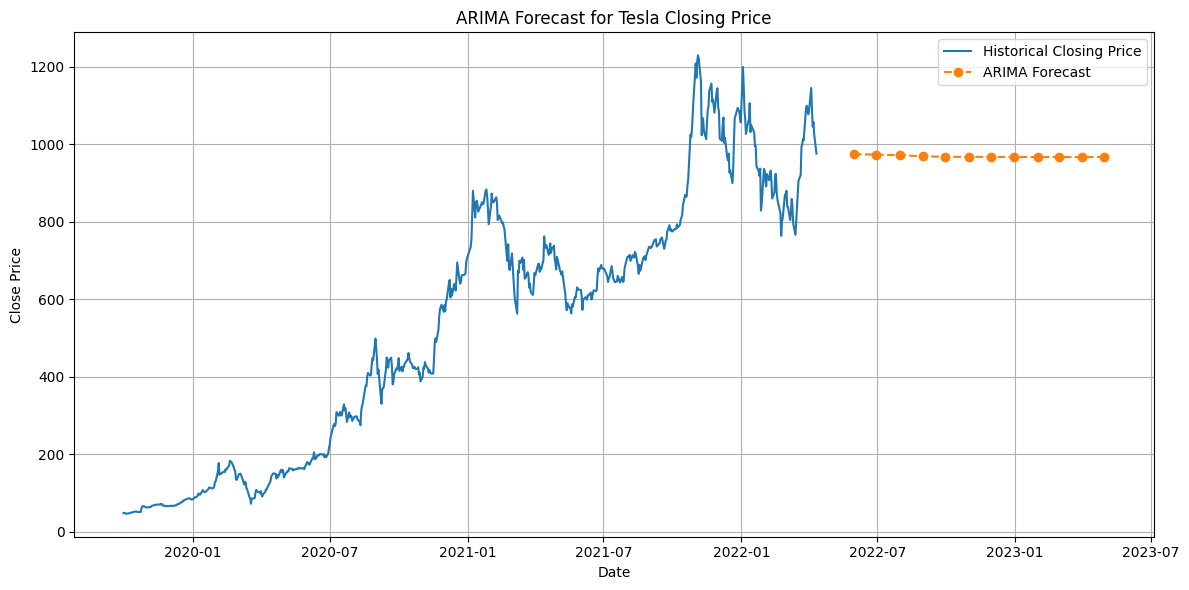

In [8]:
# ARIMA model
# Load your cleaned data
data = pd.read_csv('/content/drive/My Drive/TSLA.csv')
# Use unscaled closing price (you must use original scale for ARIMA)
close_data = df['Close']

# Train ARIMA model (order can be tuned)
model = ARIMA(close_data, order=(5, 1, 0))  # (p=5, d=1, q=0) is a common starting point
model_fit = model.fit()

# Forecast next 12 months
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

# Create time index for future predictions
last_date = df['Date'].iloc[-1]
forecast_dates = pd.date_range(last_date, periods=forecast_steps + 1, freq='M')[1:]

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], close_data, label='Historical Closing Price')
plt.plot(forecast_dates, forecast, label='ARIMA Forecast', marker='o', linestyle='--')
plt.title('ARIMA Forecast for Tesla Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Random Forest with GridSearch Results:
Best Parameters: {'max_depth': 5, 'n_estimators': 50}
MAE: 20.40
RMSE: 30.51


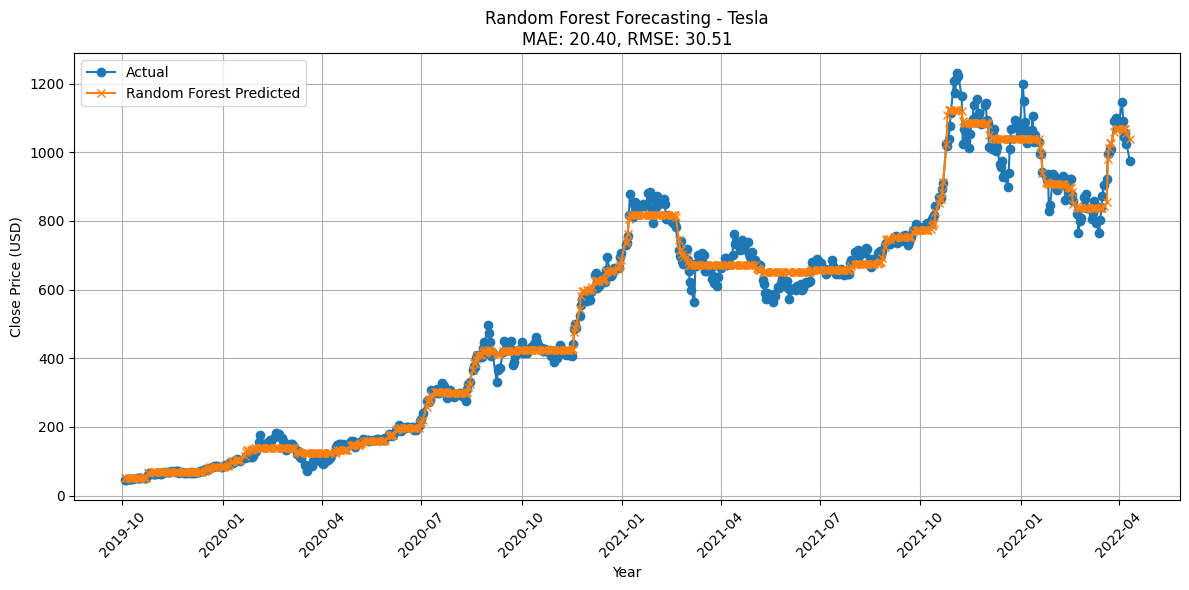

In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv('/content/drive/My Drive/TSLA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Scale target (Close)
scaler = MinMaxScaler()
df['Close_Scaled'] = scaler.fit_transform(df[['Close']])

# Create supervised features
def create_supervised_data(data, window=3):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_supervised_data(df['Close_Scaled'].values, window=window_size)

# Flatten input shape to fit GridSearchCV expectation (1D for sklearn API)
X_flat = np.arange(len(y)).reshape(-1, 1)

# Hyperparameter tuning with GridSearch
rf_model = RandomForestRegressor()
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
rf_grid_search = GridSearchCV(rf_model, rf_params, scoring='neg_mean_squared_error', cv=3)
rf_grid_search.fit(X_flat, y)

# Predict using best model
rf_best_model = rf_grid_search.best_estimator_
rf_predictions_scaled = rf_best_model.predict(X_flat)

# Inverse transform predictions
rf_predictions = scaler.inverse_transform(rf_predictions_scaled.reshape(-1, 1)).flatten()
y_actual = scaler.inverse_transform(y.reshape(-1, 1)).flatten()

# Evaluation
mae = mean_absolute_error(y_actual, rf_predictions)
rmse = np.sqrt(mean_squared_error(y_actual, rf_predictions))

print("Random Forest with GridSearch Results:")
print("Best Parameters:", rf_grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Use date values aligned with target variable
date_index = df['Date'].values[window_size:]

# Plot with actual years
plt.figure(figsize=(12, 6))
plt.plot(date_index, y_actual, label='Actual', marker='o')
plt.plot(date_index, rf_predictions, label='Random Forest Predicted', marker='x')
plt.title(f"Random Forest Forecasting - Tesla\nMAE: {mae:.2f}, RMSE: {rmse:.2f}")
plt.xlabel("Year")
plt.ylabel("Close Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
MAE: 48.33
RMSE: 61.94


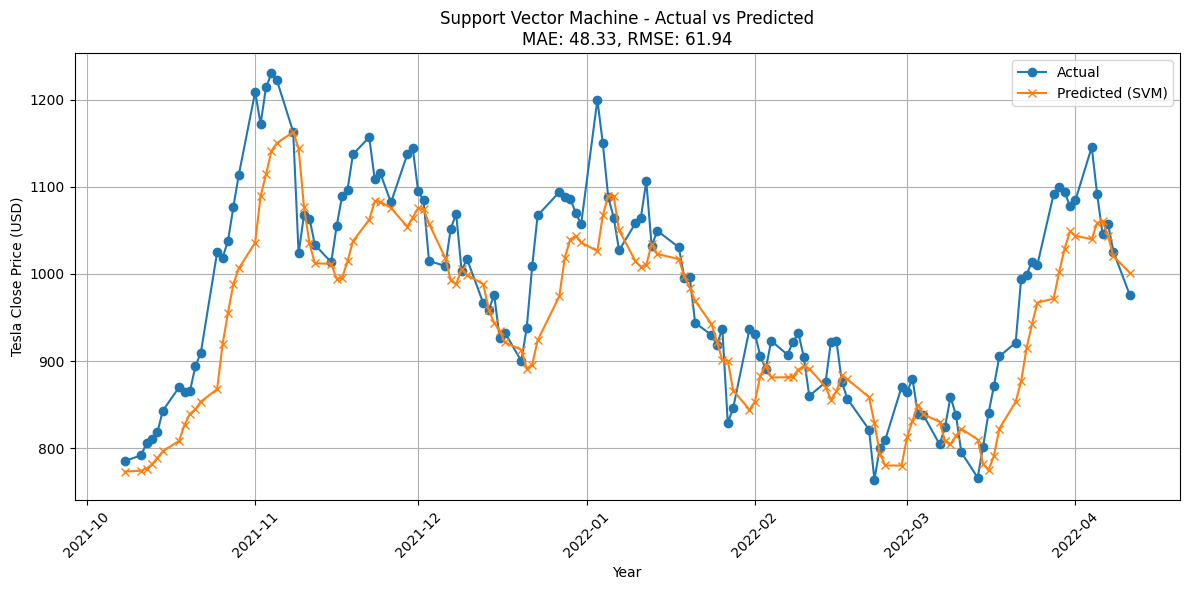

In [78]:
# SVM model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv('/content/drive/My Drive/TSLA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Use only closing prices
close_prices = df['Close'].values.reshape(-1, 1)

# Scale the target (Close price)
target_scaler = MinMaxScaler()
scaled_close = target_scaler.fit_transform(close_prices).flatten()

# Create supervised dataset using sliding window
def create_supervised_data(data, window=3):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_supervised_data(scaled_close, window=window_size)

# Split into train/test sets (no shuffle for time series)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Scale input features
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Grid search with time series split
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf','linear']
}

tscv = TimeSeriesSplit(n_splits=5)
svm = SVR()
grid_search = GridSearchCV(svm, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best model
svm_best_model = grid_search.best_estimator_
svm_predictions_scaled = svm_best_model.predict(X_test_scaled)

# Inverse transform predictions and actual values
svm_predictions = target_scaler.inverse_transform(svm_predictions_scaled.reshape(-1, 1)).flatten()
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
mae = mean_absolute_error(y_test_unscaled, svm_predictions)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, svm_predictions))

print("Best Params:", grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Create a date index aligned with y_test
date_index = df['Date'].values[window_size + split:]  # match length of y_test
# Plot Actual vs Predicted for SVM
plt.figure(figsize=(12, 6))
plt.plot(date_index, y_test_unscaled, label='Actual', marker='o')
plt.plot(date_index, svm_predictions, label='Predicted (SVM)', marker='x')
plt.title(f'Support Vector Machine - Actual vs Predicted\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Year')
plt.ylabel('Tesla Close Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



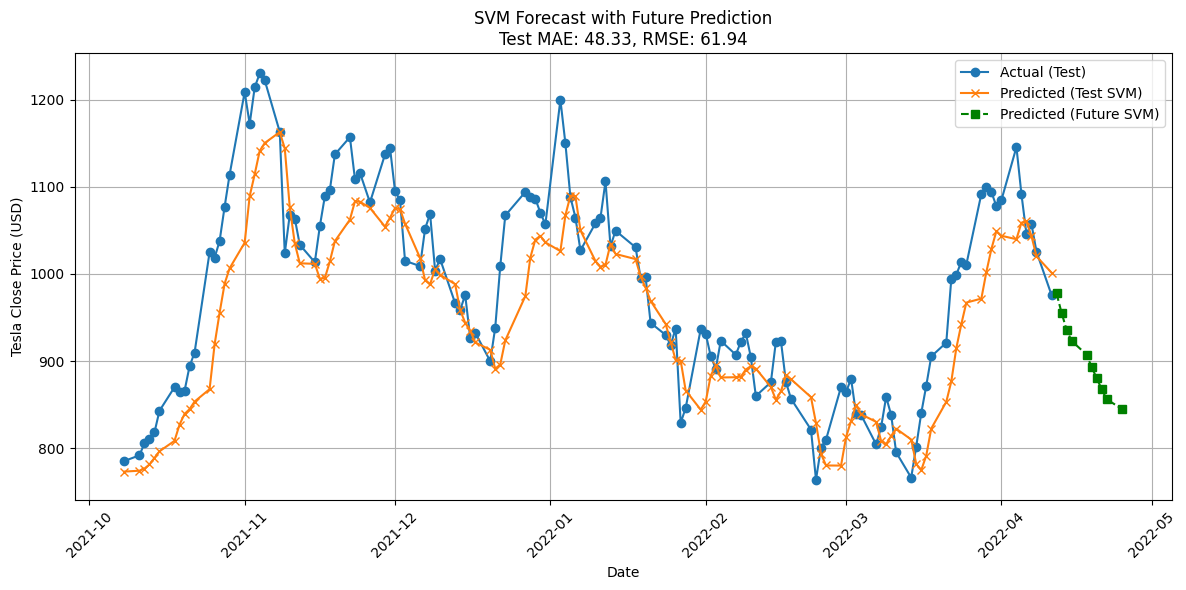


Predicted Tesla closing prices for next future days (SVM):
2022-04-12: 977.72
2022-04-13: 955.51
2022-04-14: 936.12
2022-04-15: 923.22
2022-04-18: 907.44
2022-04-19: 893.32
2022-04-20: 880.52
2022-04-21: 867.95
2022-04-22: 856.28
2022-04-25: 845.30


In [87]:
# SVM FUTURE RECURSIVE PREDICTION
def predict_future_recursive_svm(model, last_window, num_predictions, feature_scaler, target_scaler):
    predictions_scaled = []
    current_window = last_window.copy()

    for _ in range(num_predictions):
        # Scale the input window using feature scaler
        input_scaled = feature_scaler.transform(current_window.reshape(1, -1))

        # Predict next scaled target
        pred_scaled = model.predict(input_scaled)[0]
        predictions_scaled.append(pred_scaled)

        # Update current window: drop first, append pred_scaled
        current_window = np.append(current_window[1:], pred_scaled)

    # Inverse scale predictions
    predictions_unscaled = target_scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()
    return predictions_unscaled

# Prepare last window
last_window_raw = scaled_close[-window_size:]  # shape: (window_size,)
last_window_for_svm = last_window_raw.reshape(1, -1)

# Generate future predictions
num_future_predictions = 10
future_prices_svm = predict_future_recursive_svm(svm_best_model, last_window_raw, num_future_predictions, feature_scaler, target_scaler)

# Generate future dates
future_dates = pd.bdate_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=num_future_predictions)

# Plot actual test, predicted test, future predicted
plt.figure(figsize=(12, 6))
plt.plot(date_index, y_test_unscaled, label='Actual (Test)', marker='o')
plt.plot(date_index, svm_predictions, label='Predicted (Test SVM)', marker='x')
plt.plot(future_dates, future_prices_svm, label='Predicted (Future SVM)', marker='s', linestyle='--', color='green')

plt.title(f'SVM Forecast with Future Prediction\nTest MAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Date')
plt.ylabel('Tesla Close Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print future predictions
print("\nPredicted Tesla closing prices for next future days (SVM):")
for date, price in zip(future_dates, future_prices_svm):
    print(f"{date.date()}: {price:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
 LSTM Forecast Results
MAE  : 33.62
RMSE : 43.79


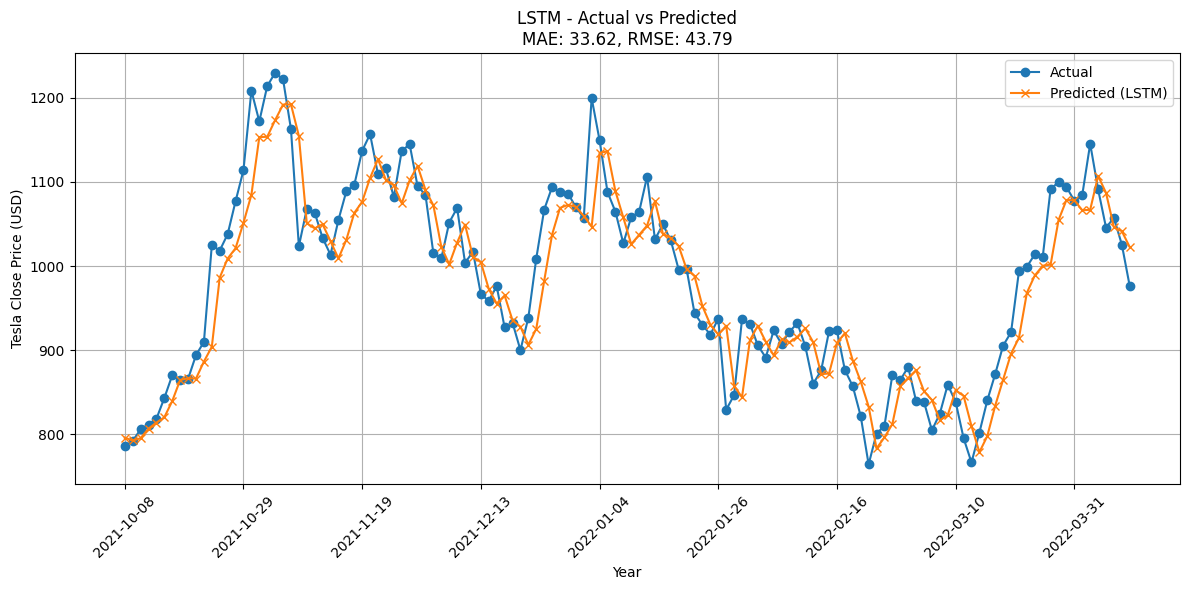

In [69]:
#  LSTM model
#Load and Prepare Dataset
data = pd.read_csv('/content/drive/My Drive/TSLA.csv')
df = data.copy()

#Scale Only the 'Close' Column
close_scaler = RobustScaler()
df['Close_Scaled'] = close_scaler.fit_transform(df[['Close']])

#Create Sliding Window Sequences
def create_sequence(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_sequence(df['Close_Scaled'].values, window_size)

#Train-Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

#Reshape Input for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

#Build and Train LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='tanh', input_shape=(window_size, 1)))
model_lstm.add(Dense(1))
model_lstm.compile( loss='mse')

print("Training LSTM...")
model_lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

# Make Predictions and Inverse Transform
pred_lstm = model_lstm.predict(X_test)
pred_lstm_unscaled = close_scaler.inverse_transform(pred_lstm)
y_test_unscaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
mae = mean_absolute_error(y_test_unscaled, pred_lstm_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, pred_lstm_unscaled))
print(" LSTM Forecast Results")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

# Create a date index aligned with y_test
date_index = df['Date'].values[window_size + split:]  # match length of y_test
# Plot Actual vs Predicted for LSTM
plt.figure(figsize=(12, 6))
plt.plot(date_index, y_test_unscaled, label='Actual', marker='o')
plt.plot(date_index, pred_lstm_unscaled, label='Predicted (LSTM)', marker='x')
plt.title(f'LSTM - Actual vs Predicted\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Year')
plt.ylabel('Tesla Close Price (USD)')
# Set x-ticks to show fewer labels
plt.xticks(ticks=np.arange(0, len(date_index), step=15), labels=date_index[::15], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Future Closing Price Predictions:
[1007.65883482 1012.83205852 1026.19529115 1040.11845296 1052.85621874
 1064.52141005 1075.47228478 1085.88852172 1095.84614161 1105.43487388]


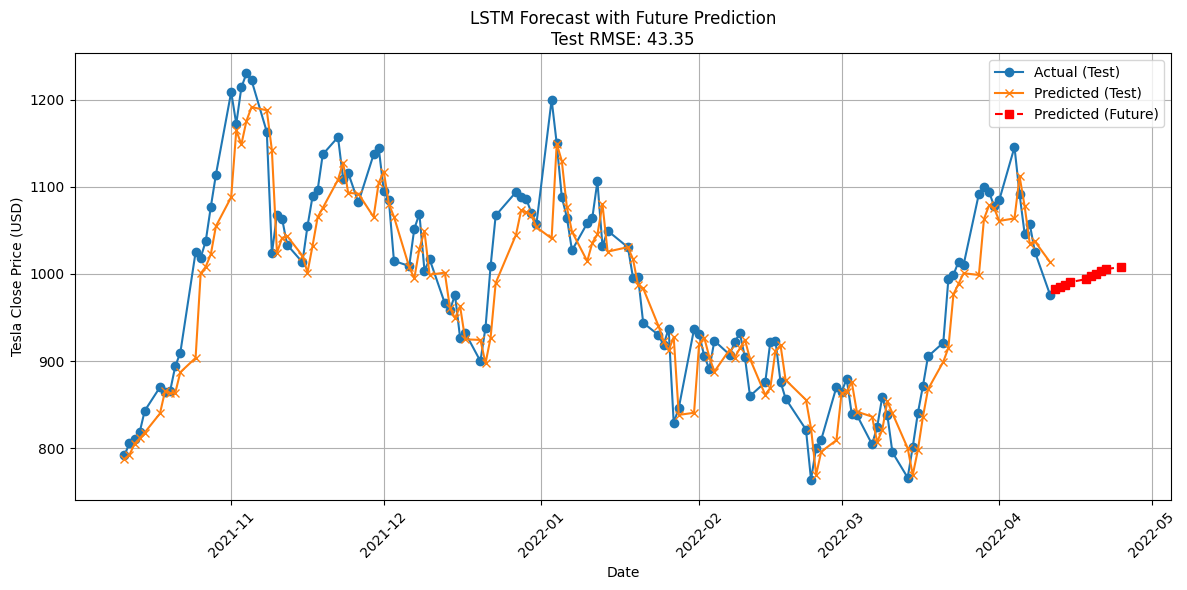

In [65]:
# LSTM FUTURE RECURSIVE PREDICTION

def predict_future_recursive_lstm(model, last_window, num_predictions, scaler):
    predictions = []
    current_window = last_window.copy()

    for _ in range(num_predictions):
        input_data = current_window.reshape(1, len(current_window), 1)  # reshape for LSTM
        pred_scaled = model.predict(input_data, verbose=0)[0, 0]
        predictions.append(pred_scaled)

        # update window: drop first, append prediction
        current_window = np.append(current_window[1:], pred_scaled)

    # inverse transform predictions
    predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return predictions_unscaled

# Generate future predictions
num_future_predictions = 10  # set how many future points you want
last_window_scaled = df['Close_Scaled'].values[-window_size:]

future_prices = predict_future_recursive_lstm(model_lstm, last_window_scaled, num_future_predictions, close_scaler)

# Ensure df['Date'] is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Slice test dates
test_dates = df['Date'].iloc[window_size + split:]

# Print the predicted future closing prices
print("Future Closing Price Predictions:")
print(future_predictions)

# Plot with consistent date type
plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_unscaled, label='Actual (Test)', marker='o')
plt.plot(test_dates, pred_lstm_unscaled, label='Predicted (Test)', marker='x')
plt.plot(future_dates, future_prices, label='Predicted (Future)', marker='s', linestyle='--', color='orange')

plt.title(f'LSTM Forecast with Future Prediction\nTest RMSE: {rmse:.2f}')
plt.xlabel('Date')
plt.ylabel('Tesla Close Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Bidirectional LSTM...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
 Bidirectional LSTM Forecast Results
MAE  : 31.26
RMSE : 41.33


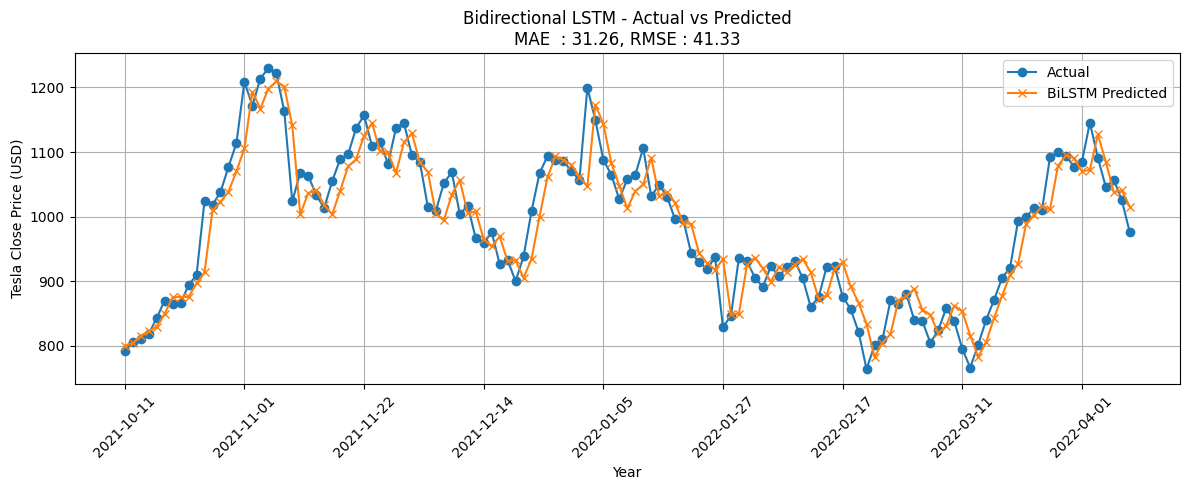

In [62]:
# Bidirectional LSTM
#Load and Prepare Dataset
data = pd.read_csv('/content/drive/My Drive/TSLA.csv')
df = data.copy()

# Scale Only the 'Close' Column
close_scaler = MinMaxScaler()
df['Close_Scaled'] = close_scaler.fit_transform(df[['Close']])

#Create Sliding Window Sequences
def create_sequence(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 7
X, y = create_sequence(df['Close_Scaled'].values, window=window_size)

# Train-Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape Input for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build and Train model
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(64, activation='relu'), input_shape=(window_size, 1)))
model_bilstm.add(Dense(1))
model_bilstm.compile(optimizer='adam', loss='mse')

print("Training Bidirectional LSTM...")
model_bilstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

# Make Predictions and Inverse Transform
pred_bilstm = model_bilstm.predict(X_test)
pred_bilstm_unscaled = close_scaler.inverse_transform(pred_bilstm)
y_test_unscaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
mae_bilstm = mean_absolute_error(y_test_unscaled, pred_bilstm_unscaled)
rmse_bilstm = np.sqrt(mean_squared_error(y_test_unscaled, pred_bilstm_unscaled))

print(" Bidirectional LSTM Forecast Results")
print(f"MAE  : {mae_bilstm:.2f}")
print(f"RMSE : {rmse_bilstm:.2f}")

# Create a date index aligned with y_test
date_index = df['Date'].values[window_size + split:]  # match length of y_test

# Plot Actual vs Predicted
plt.figure(figsize=(12, 5))
plt.plot(y_test_unscaled, label='Actual', marker='o')
plt.xticks(ticks=np.arange(0, len(date_index), step=15), labels=date_index[::15], rotation=45)
plt.plot(pred_bilstm_unscaled, label='BiLSTM Predicted', marker='x')
plt.title(f'Bidirectional LSTM - Actual vs Predicted\nMAE  : {mae_bilstm:.2f}, RMSE : {rmse_bilstm:.2f}')
plt.xlabel('Year')
plt.ylabel('Tesla Close Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Future Closing Price Predictions:
[1007.65883482 1012.83205852 1026.19529115 1040.11845296 1052.85621874
 1064.52141005 1075.47228478 1085.88852172 1095.84614161 1105.43487388]


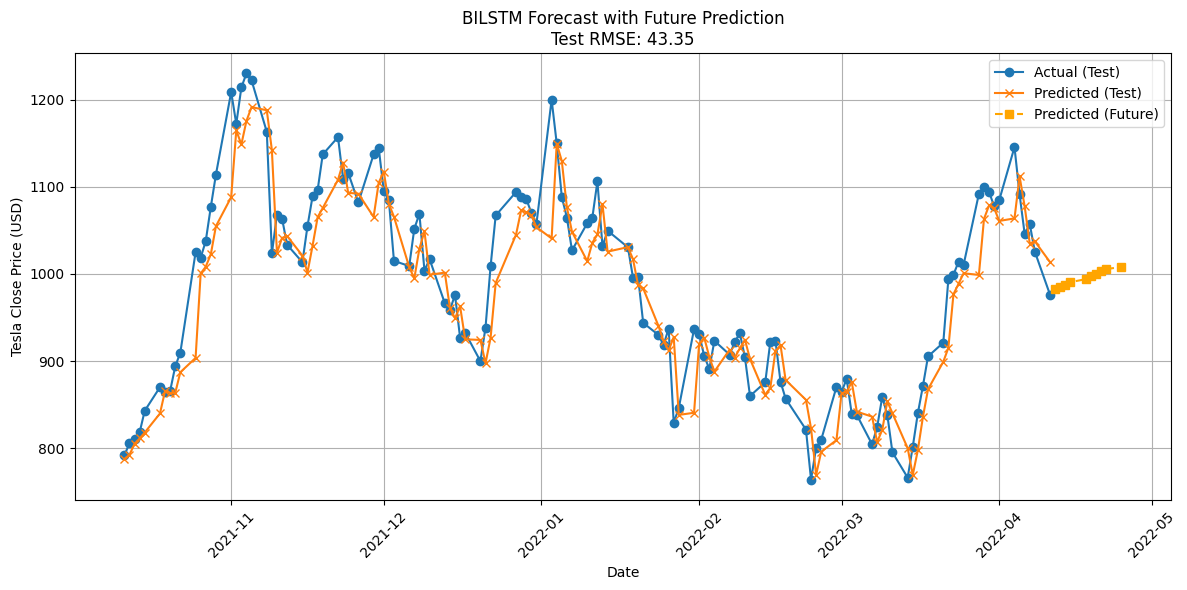

In [64]:
# BILSTM FUTURE RECURSIVE PREDICTION

def predict_future_recursive_lstm(model, last_window, num_predictions, scaler):
    predictions = []
    current_window = last_window.copy()

    for _ in range(num_predictions):
        input_data = current_window.reshape(1, len(current_window), 1)  # reshape for BILSTM
        pred_scaled = model.predict(input_data, verbose=0)[0, 0]
        predictions.append(pred_scaled)

        # update window: drop first, append prediction
        current_window = np.append(current_window[1:], pred_scaled)

    # inverse transform predictions
    predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return predictions_unscaled

# Generate future predictions
num_future_predictions = 10  # set how many future points you want
last_window_scaled = df['Close_Scaled'].values[-window_size:]

future_prices = predict_future_recursive_lstm(model_lstm, last_window_scaled, num_future_predictions, close_scaler)

# Ensure df['Date'] is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Slice test dates
test_dates = df['Date'].iloc[window_size + split:]

# Print the predicted future closing prices
print("Future Closing Price Predictions:")
print(future_predictions)

# Plot with consistent date type
plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_unscaled, label='Actual (Test)', marker='o')
plt.plot(test_dates, pred_lstm_unscaled, label='Predicted (Test)', marker='x')
plt.plot(future_dates, future_prices, label='Predicted (Future)', marker='s', linestyle='--', color='orange')

plt.title(f'BILSTM Forecast with Future Prediction\nTest RMSE: {rmse:.2f}')
plt.xlabel('Date')
plt.ylabel('Tesla Close Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [93]:
!pip install pytest

In [97]:
test_code = """
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# === Sample fixture-like setup ===
# You can move this into a pytest fixture if preferred
df = pd.read_csv('/content/drive/My Drive/TSLA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
scaler = MinMaxScaler()
df['Close_Scaled'] = scaler.fit_transform(df[['Close']])
window_size = 3

# Helper to create supervised data
def create_supervised_data(data, window=3):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_supervised_data(df['Close_Scaled'].values, window=window_size)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Fit a simple model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
pred_scaled = model_lr.predict(X_test)
pred_unscaled = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

#TESTS

def test_close_scaled_range():
    #Test Close_Scaled range.
    assert df['Close_Scaled'].min() >= 0, "Close_Scaled min below 0"
    assert df['Close_Scaled'].max() <= 1, "Close_Scaled max above 1"

def test_supervised_data_shapes():
    #Test shapes of X and y.
    assert X.shape[0] == len(df) - window_size, "X rows mismatch"
    assert X.shape[1] == window_size, "X columns (window) mismatch"
    assert len(X) == len(y), "X and y length mismatch"

def test_prediction_length():
    #Test prediction length
    assert len(pred_unscaled) == len(y_test_unscaled), "Prediction length mismatch"

def test_future_prediction_length():
  #Test future prediction length.
    num_future_predictions = 10
    last_window_scaled = df['Close_Scaled'].values[-window_size:]
    future_preds_scaled = []

    current_window = last_window_scaled.copy()
    for _ in range(num_future_predictions):
        input_data = current_window.reshape(1, -1)
        pred = model_lr.predict(input_data)[0]
        future_preds_scaled.append(pred)
        current_window = np.append(current_window[1:], pred)

    future_unscaled = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()
    assert len(future_unscaled) == num_future_predictions, "Future prediction length mismatch"
    assert (future_unscaled > 0).all(), "Some future prices are non-positive"

def test_inverse_scaler_restores_close():
    #Test inverse scaler restores original 'Close' values.
    first_close = df['Close'].iloc[0]
    scaled = scaler.transform([[first_close]])
    restored = scaler.inverse_transform(scaled)[0,0]
    assert np.isclose(restored, first_close, atol=1e-3), "Scaler inverse mismatch"

"""

# Save to file
with open("test_ml_pipeline.py", "w") as f:
    f.write(test_code)


In [98]:
!pytest -v test_ml_pipeline.py


============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.3.5, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content
plugins: anyio-4.9.0, langsmith-0.3.45, typeguard-4.4.3
collected 5 items                                                              

test_ml_pipeline.py::test_close_scaled_range PASSED                      [ 20%]
test_ml_pipeline.py::test_supervised_data_shapes PASSED                  [ 40%]
test_ml_pipeline.py::test_prediction_length PASSED                       [ 60%]
test_ml_pipeline.py::test_future_prediction_length PASSED                [ 80%]
test_ml_pipeline.py::test_inverse_scaler_restores_close PASSED           [100%]

=============================== warnings summary ===============================
test_ml_pipeline.py::test_inverse_scaler_restores_close
  /usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na